This Code is designed to be used in Google Colab and Google Cloud Environment by Ali Abyaneh.
**Bachelor Thesis, Extracting Images From EEG signals.**

The following code attempts to classify an EEG dataset, which is *The "MNIST" of Brain Digits*, into three categories, namely, first digits(0-9), second digits(0-9), and noise which is a digit observed by the observor other than first two digits. The goal and results are elucidated in the readme at master branch of this repository.

Feel free to use this code if it can be helpful for you!

*Author : Ali Abyaneh*

As it was cleared above, this code is written to be used on google colab, so in the follwoing section we add google drive to the google colab so as to use the dataset which is uploaded in my gdrive.

In [0]:
from google.colab import drive
drive.mount('/gdrive')
import os
import zipfile
cwd = os.getcwd()
print(cwd)
os.chdir("../../")
os.chdir("../gdrive/My Drive")
cwd = os.getcwd()
print(cwd)

The following code is used to import neccessary libraies.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np

!pip install scipy
from scipy import signal

In the following cell, we read the dataset, that is, *"EP1.01.txt"*, and parse it into different categories. Data is selected from 14 different location of the brain, the graph of which is shown below.

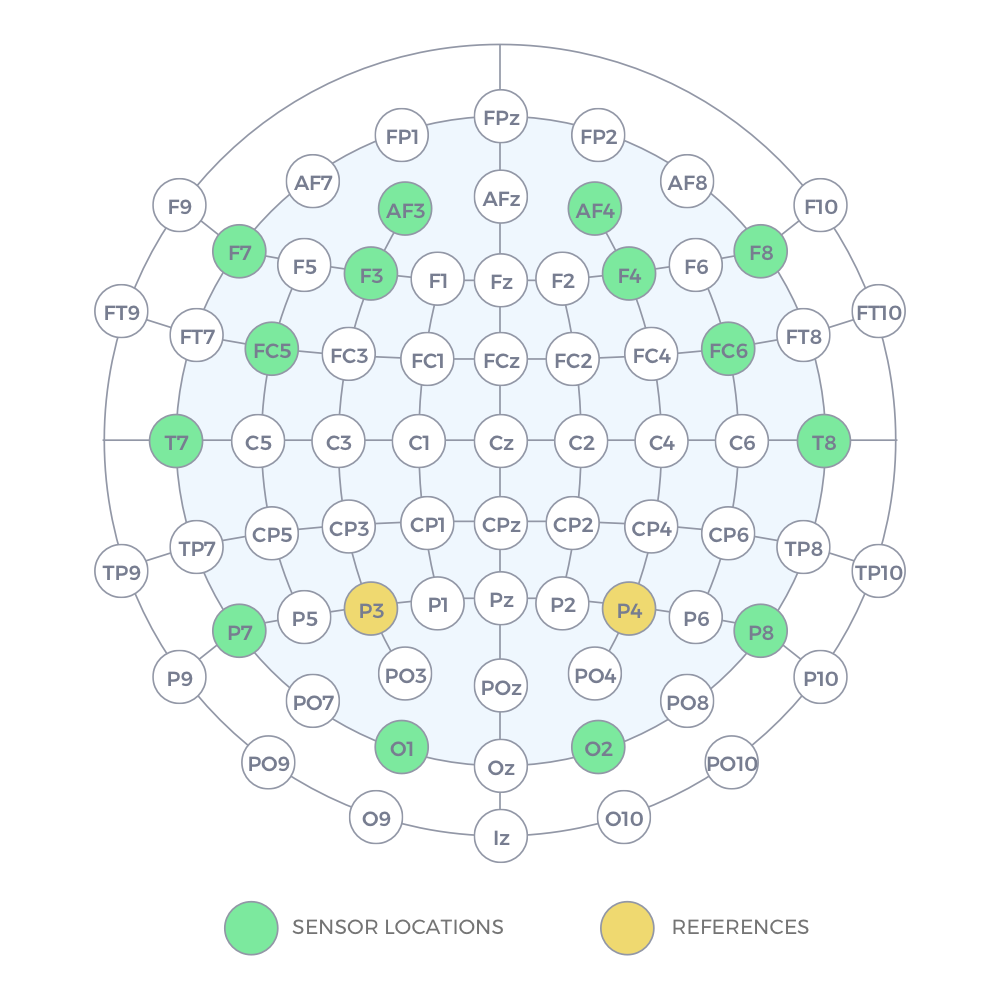

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np


EPOC_Brain_location = {"AF3" : 0,
                  "F7"  : 1,
                  "F3"  : 2,
                  "FC5" : 3,
                  "T7"  : 4,
                  "P7"  : 5,
                  "O1"  : 6,
                  "O2"  : 7,
                  "P8"  : 8, 
                  "T8"  : 9,
                  "FC6" : 10,
                  "F4"  : 11,
                  "F8"  : 12,
                  "AF4" : 13}
MW_Brain_location = {"FP1" : 0}
N_Samples_device = {"MindWave" : 1024,
          "EPOC"     : 256 
          }
def Load_data(infile, device, data_size = 100, event_start_point = 67635, split_data = False):
    if device == "EPOC":
        Brain_location = EPOC_Brain_location
    elif device == "MindWave":
        Brain_location = MW_Brain_location
    N_locations = len(Brain_location)
    test_size = int(0.2 * data_size)
    train_size = data_size - test_size
    N_data = N_Samples_device[device]
    if N_locations > 1:
        arr = np.zeros([data_size, N_locations, N_data])
    else:
        arr = np.zeros([data_size, N_data], dtype = 'int32')
    label = np.zeros([data_size], dtype = 'int32')
    for i in range(N_locations*data_size):
        
        temp = infile.readline()
        if len(temp) < 10:
            break
        x = temp.split()
        header = x[0:6]
        event = int(header[1]) - event_start_point
        channel = Brain_location[header[3]]
        temp = x[6].split(',')
        while len(temp) < N_data:
            temp.append('0')
        n = int(header[4])
#        print(n)
        if N_locations > 1:
            arr[i//N_locations][channel] = list(map(float,temp))[:N_data]
        else:
            arr[i//N_locations] = list(map(float,temp))[:N_data]
        label[i//N_locations] = n
    if split_data == True:
        return arr[0:train_size], label[0:train_size], arr[train_size:data_size], label[train_size:data_size]
    return arr, label
def EPOC_Load_data(infile, data_size = 100, event_start_point = 67635):
    N_locations = 14
    test_size = int(0.2 * data_size)
    train_size = data_size - test_size
    N_data = 256
    arr = np.zeros([data_size, N_locations, N_data])
    label = np.zeros([data_size], dtype = 'int32')
    for i in range(N_locations*data_size):
        
        temp = infile.readline()
        if len(temp) < 10:
            break
        x = temp.split()
        header = x[0:6]
        event = int(header[1]) - event_start_point
        channel = EPOC_Brain_location[header[3]]
        temp = x[6].split(',')
        while len(temp) < N_data:
            temp.append('0')
        n = int(header[4])
        if(n != -1):
            arr[event][channel] = list(map(float,temp))[:N_data]
            label[event] = n
    return arr,label

def get_specific_data(arr, labels, l1, l2):
    data = [[] for i in range(10)]
    for i in range(len(arr)):
        data[labels[i]].append(arr[i].transpose())
    length = 0
    for i in range(10):
        length = length + len(data[i])
    length = length // 4
    tags = []
    content = []
    for i in range(length):
        if i < len(data[l1]):
            tags.append(0)
            content.append(data[l1][i])
        elif i < len(data[l1]) + len(data[l2]):
            tags.append(1)
            content.append(data[l2][i - len(data[l1])])
        else:
            tags.append(2)
    for i in range(10):
        if i != l1 and i != l2:
            for j in range(len(data[i]) // 7):
                content.append(data[i][j])
    while len(tags) < len(content):
      tags.append(2)
    return content, tags
    
Size_of_data = 40000
First_Digit = 2
Second Digit = 4
File_Location = "EP1.01.txt"
    
infile = open(File_Location)
data, labels = EPOC_Load_data(infile, data_size = Size_of_data)

content, tags = get_specific_data(data, labels, First_Digit, Second Digit)
del data
del labels
data = np.asarray(content)
labels = np.asarray(tags)

In [0]:
print(data.shape)

The **sklearn.model_selection** is used to shuffle data and split it into test and train part. 

In [0]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.20, shuffle= True)

The Neural Network architecure is defined below. The hyper paramers such as number of layers, number of filters in each layer and to name but two, may vary for different digits. The common structure is depicted in the below graph:

![Sparse_CNN.png](Sparse_CNN.png)

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=np.shape(x_train)[1:]))
model.add(tf.keras.layers.Conv1D(128, 11, padding='same', activation='tanh'))
model.add(tf.keras.layers.AveragePooling1D(pool_size=(4)))
model.add(tf.keras.layers.Dropout(0.5))



model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(256, 11, padding='same', activation='tanh'))
model.add(tf.keras.layers.AveragePooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))


# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv1D(128, 8, padding='same', activation='elu'))
# model.add(tf.keras.layers.AveragePooling1D(pool_size=(4)))
# model.add(tf.keras.layers.Dropout(0.25))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dense(3))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

In [0]:
print(np.shape(x_train))
xx = x_train[:,0,:]
print(xx.shape)

The model uses TPU to speed up learning procedure. $$\alpha$$is the learning rate. 

In [0]:
import os
import datetime

alpha = 2e-3
batch_size = 256
num_epochs = 3000

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
tpu_model.compile(
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=alpha, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy', 'accuracy']
)

# model.save('CNN1D_model_EPOC.h5')  # creates a HDF5 file 'my_model.h5'
filepath = "./CNN1D_model_EPOC_s24/weights24-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkPointer = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=False, mode='auto', monitor='val_acc')
logdir="./CNN1D_model_EPOC_s24/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorBoard = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, train_data.shape[0] - batch_size)
    yield train_data[offset:offset+batch_size], train_labels[offset:offset + batch_size]
    

History = tpu_model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs=num_epochs,
    validation_data = (x_valid, y_valid),
    callbacks = [checkPointer,tensorBoard]
)
import pickle
with open('./CNN1D_model_EPOC/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(History.history, file_pi)